# MALARIA DETECTION

### Import Necessary Libraries

In [4]:
# Common 
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 

# Data
from keras.preprocessing.image import ImageDataGenerator

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Transfer Learning Models
from tensorflow.keras.applications import ResNet50, ResNet50V2


### Prepare the Dataset

In [5]:

datagen = ImageDataGenerator(rescale=1./255)

train_ds = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    
)



val_ds = datagen.flow_from_directory(
   'dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
   
)


test_ds = datagen.flow_from_directory(
   'dataset/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
)

Found 19250 images belonging to 2 classes.
Found 5500 images belonging to 2 classes.
Found 2750 images belonging to 2 classes.


### checking classnames

In [6]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['Parasitized', 'Uninfected']


In [7]:
def show_image(img, title=None):
    '''The function takes in a Image and plots it'''
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

In [8]:
def get_random_data(data):
    images, labels = data
    id = np.random.randint(len(images))
    image, label = images[id], labels[id]
    return image, label

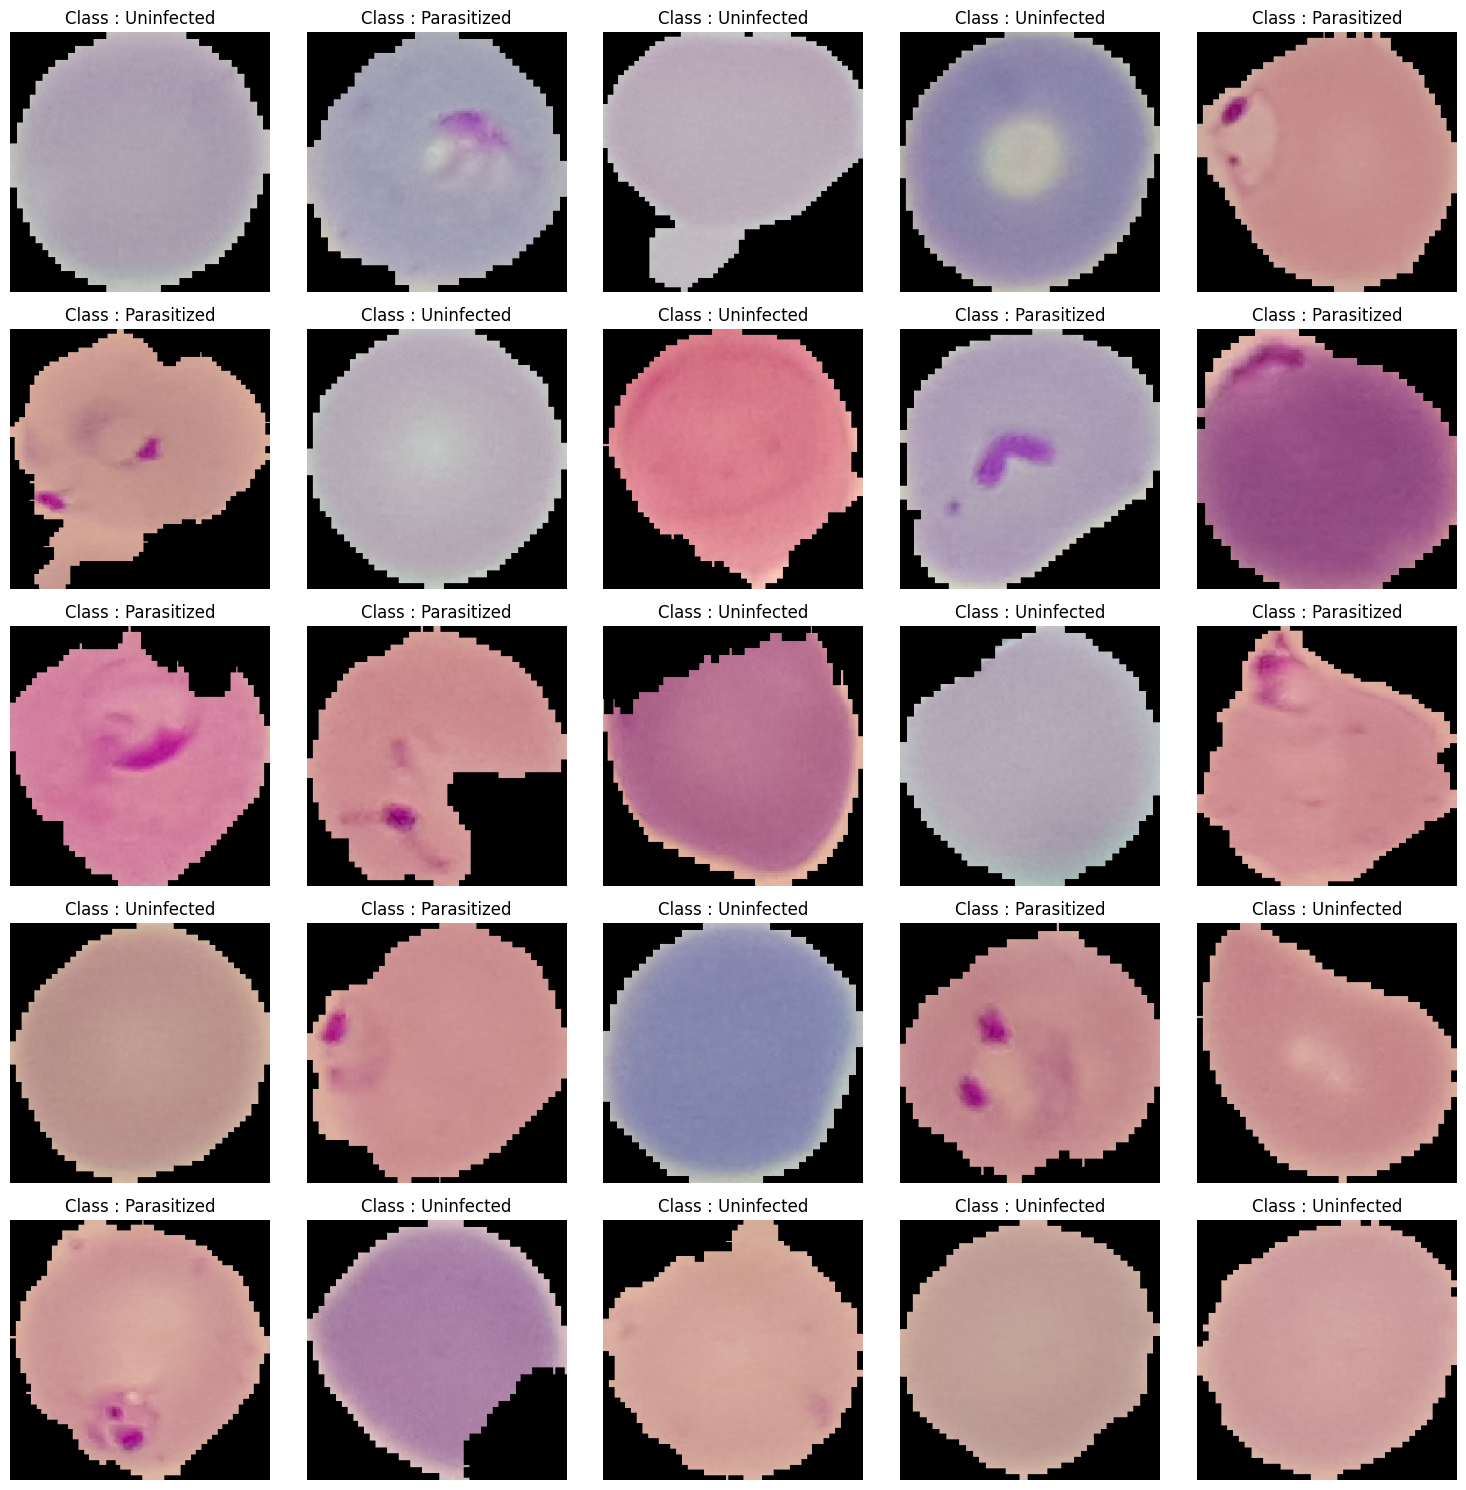

In [9]:
plt.figure(figsize=(15,15))
i=1
for images, labels in iter(train_ds):
    
    # Get Random Image and label
    image, label = get_random_data([images, labels])
    
    # Plot it
    plt.subplot(5,5,i)
    show_image(image, title=f"Class : {class_names[int(label)]}")
    
    # Make sure to end the Loop
    i+=1
    if i>=26: break
        

plt.tight_layout()
plt.show()

In [10]:
x,y = test_ds.next()
x.shape

(1, 224, 224, 3)

###  Build the Model

##### Specify Model Name

In [11]:
name = "maleria_detection"
base_model = ResNet50V2(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False # Freeze the Weights

x = GAP()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions, name=name)

##### Compile the Model

In [12]:
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy'])

##### Callbacks

In [13]:
cbs = [
     EarlyStopping(patience=3, restore_best_weights=True),
     ModelCheckpoint(name + ".h5", save_best_only=True)
 ]

##### Model Summary

In [14]:
model.summary()

Model: "maleria_detection"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

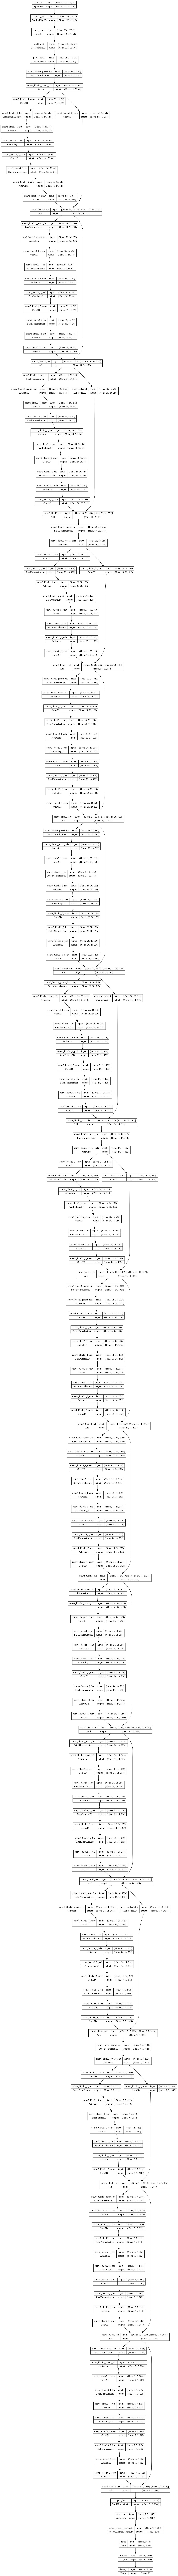

In [15]:
plot_model(
    model, dpi=120,
    show_shapes=True
)

### Train the model

In [26]:
history = model.fit(
     train_ds, validation_data=val_ds,
     epochs=50, callbacks=cbs
 )

Epoch 1/50
602/602 [==============================] - 70s 108ms/step - loss: 0.2105 - accuracy: 0.9203 - val_loss: 0.1536 - val_accuracy: 0.9429
Epoch 2/50
602/602 [==============================] - 63s 105ms/step - loss: 0.1526 - accuracy: 0.9419 - val_loss: 0.1621 - val_accuracy: 0.9365
Epoch 3/50
602/602 [==============================] - 63s 105ms/step - loss: 0.1364 - accuracy: 0.9481 - val_loss: 0.1603 - val_accuracy: 0.9396
Epoch 4/50
602/602 [==============================] - 64s 106ms/step - loss: 0.1330 - accuracy: 0.9485 - val_loss: 0.1649 - val_accuracy: 0.9402


### Model Evaluation

In [21]:
scores = model.evaluate(test_ds)

2750/2750 [==============================] - 28s 10ms/step - loss: 0.1624 - accuracy: 0.9407


In [22]:
scores

[0.16235345602035522, 0.9407272934913635]

### Saving the Model

In [38]:
import os
model_files = [int(i) for i in os.listdir("models") if i.isdigit()] + [0]
model_version = max(model_files) + 1
model.save(f"models/version_{model_version}")

INFO:tensorflow:Assets written to: models/version_4\assets


INFO:tensorflow:Assets written to: models/version_4\assets


In [39]:
model.save("models/malaria_detection.h5")

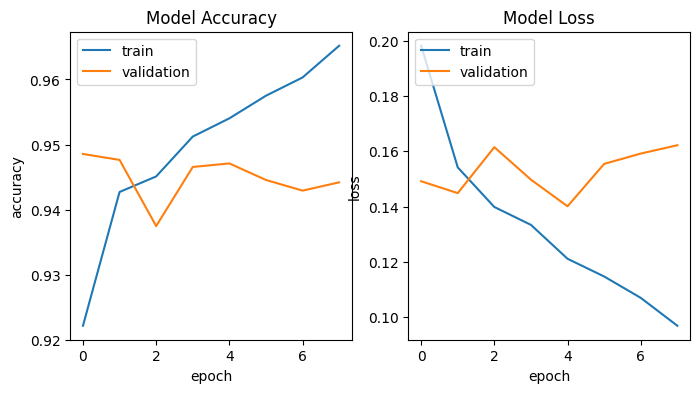

In [40]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()